In [1]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import gala.coordinates as gc
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()
import yaml

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [8]:
def lons_lats(pos, vel):
    prog = gd.PhaseSpacePosition(pos[0] * u.kpc, vel[0] * u.km / u.s)
    stream = gd.PhaseSpacePosition(pos[1:].T * u.kpc, vel[1:].T * u.km / u.s)
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  

    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()

    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    lon = stream_sph.lon.wrap_at(180*u.deg).degree
    lat = stream_sph.lat.degree
    return lon, lat

def local_veldis(lons, vfs):

    # Compute percentiles
    lower_value = np.nanpercentile(lons, 0.1)
    upper_value = np.nanpercentile(lons, 99.9)
    # Filter lons_mainbody
    lons_mainbody = lons[(lons >= lower_value) & (lons <= upper_value)]
    vfs_mainbody = vfs[1:][(lons >= lower_value) & (lons <= upper_value)] #excludes progenitor [1:]
    # Create bins
    lon_bins = np.linspace(np.nanmin(lons_mainbody), np.nanmax(lons_mainbody), 50)
    # Compute absolute velocity norms
    vfs_absol = np.linalg.norm(vfs_mainbody, axis=1)
    # Slice lons_mainbody into bins
    bin_indices = np.digitize(lons_mainbody, lon_bins)
    # Create a mask array
    mask = np.zeros((len(lons_mainbody), len(lon_bins) - 1), dtype=bool)
    for i in range(1, len(lon_bins)):
        mask[:, i - 1] = (bin_indices == i)

    # Calculate standard deviation for each bin
    local_veldis = np.array([np.std(vfs_absol[m]) for m in mask.T])
    return np.nanmedian(local_veldis)

In [9]:
def galactic_coords(p, v):
    
    galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
    galcen_distance = 8.249*u.kpc
    
    # positions = p - Model.expansion_centres(0.)[:3]
    # velocities = v - Model.expansion_centre_velocities(0.)[:3]
    
    posvel_gc = SkyCoord(x=p[:,0]*u.kpc, y=p[:,1]*u.kpc, z=p[:,2]*u.kpc,
                         v_x=v[:,0]*u.km/u.s, v_y=v[:,1]*u.km/u.s, v_z=v[:,2]*u.km/u.s ,
                         frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
    posvel_galactic = posvel_gc.transform_to('galactic')
    posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
    l, b, d = np.nanmedian(posvel_galactic_rc.l), np.nanmedian(posvel_galactic_rc.b), np.nanmedian(posvel_galactic_rc.distance)
    pm_l_cosb, pm_b, rvs = np.nanmedian(posvel_galactic_rc.pm_l_cosb), np.nanmedian(posvel_galactic_rc.pm_b), np.nanmedian(posvel_galactic_rc.radial_velocity)
    
    sigma_rv = np.nanstd(posvel_galactic_rc.radial_velocity)
    
    return l.value, b.value, d.value, pm_l_cosb.value, pm_b.value, rvs.value, sigma_rv.value

In [4]:
def write_pltoutputs_hdf5(outpath, filename, 
                         l_gc, b_gc, ds, pm_l_cosb_gc, pm_b_gc, vlos, sigma_los,
                         peris, apos,
                         widths, lengths, lmc_sep,
                         av_lon, av_lat, loc_veldis,
                         pole_b, pole_l,
                         pole_b_dis, pole_l_dis,
                         masses, energy, Ls, Lzs):
    print("* Writing data for potential {}".format(filename))
    hf = h5py.File(outpath + filename + ".hdf5", 'w')
    hf.create_dataset('l_gc', data=l_gc)
    hf.create_dataset('b_gc', data=b_gc)
    hf.create_dataset('ds', data=ds)
    hf.create_dataset('pm_l_cosb', data=pm_l_cosb_gc)
    hf.create_dataset('pm_b', data=pm_b_gc)
    hf.create_dataset('vlos', data=vlos)
    hf.create_dataset('sigmavlos', data=sigma_los)
                      
    hf.create_dataset('pericenter',data=peris)
    hf.create_dataset('apocenter', data=apos)
                
    hf.create_dataset('lengths', data=lengths)
    hf.create_dataset('widths', data=widths)
    hf.create_dataset('lmc_sep', data=lmc_sep)
    hf.create_dataset('av_lon', data=av_lon)
    hf.create_dataset('av_lat', data=av_lat)
    hf.create_dataset('loc_veldis', data=loc_veldis)
                      
    hf.create_dataset('pole_l', data=pole_l)
    hf.create_dataset('pole_b', data=pole_b)                 
    hf.create_dataset('sigma_pole_l', data=pole_l_dis)
    hf.create_dataset('sigma_pole_b', data=pole_b_dis)
                      
    hf.create_dataset('mass', data=masses)           
    hf.create_dataset('energies', data=energy)
    hf.create_dataset('L', data=Ls)
    hf.create_dataset('Lz', data=Lzs)
    hf.close()

In [134]:
l_gc, b_gc, ds, pm_l_cosb_gc, pm_b_gc, vlos, sigma_los = [], [], [], [], [], [], []
peris, apos = [], []
widths, lengths, lmc_sep = [], [], []
av_lon, av_lat = [], []
loc_veldis = []
pole_b, pole_l = [], []
pole_b_dis, pole_l_dis = [], []
masses = []
energy, Ls, Lzs = [], [], []

path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
potential = 'full-MWhalo-full-MWdisc-no-LMC.hdf5'

Nstreams =1024 
for i in range(Nstreams):
    data_path = pathlib.Path(path) / potential 
    with h5py.File(data_path,'r') as file:
        
        if i ==0:
            filename_end = file['stream_{}'.format(i)]['potential'][()].decode('utf-8')
        
        pos = np.array(file['stream_{}'.format(i)]['positions'])[-1]
        vel = np.array(file['stream_{}'.format(i)]['velocities'])[-1]
        l, b, d,  pm_l_cosb, pm_b, rvs, sigma_rv = galactic_coords(pos, vel)
        l_gc.append(l), b_gc.append(b), ds.append(d)
        pm_l_cosb_gc.append(pm_l_cosb), pm_b_gc.append(pm_b), vlos.append(rvs)
        sigma_los.append(sigma_rv)

        peris.append(np.array(file['stream_{}'.format(i)]['pericenter']))
        apos.append(np.array(file['stream_{}'.format(i)]['apocenter']))
        lmc_sep.append(np.array(file['stream_{}'.format(i)]['lmc_sep']))
        
        widths.append(np.array(file['stream_{}'.format(i)]['width']))
        lengths.append(np.array(file['stream_{}'.format(i)]['length']))
        av_lon.append(np.array(file['stream_{}'.format(i)]['av_lon']))
        av_lat.append(np.array(file['stream_{}'.format(i)]['av_lat']))
        
        lons, lats = lons_lats(pos, vel)
        loc_veldis.append(local_veldis(lons, vel))
        
        pole_b.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['pole_b'])[-1]))
        pole_l.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['pole_l'])[-1]))
        pole_b_dis.append(np.nanstd(np.array(file['stream_{}'.format(i)]['pole_b'])[-1]))
        pole_l_dis.append(np.nanstd(np.array(file['stream_{}'.format(i)]['pole_l'])[-1]))
        
        masses.append(np.array(file['stream_{}'.format(i)]['progenitor-mass']))
        energy.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['energies'])[-1]))
        Ls.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['L'])[-1]))
        Lzs.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['Lz'])[-1]))

In [108]:
out_path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/'

write_pltoutputs_hdf5(out_path, filename_end,
                      l_gc, b_gc, ds, pm_l_cosb_gc, pm_b_gc, vlos, sigma_los,
                      peris, apos,
                     widths, lengths, lmc_sep,
                     av_lon, av_lat, loc_veldis,
                     pole_b, pole_l,
                     pole_b_dis, pole_l_dis,
                     masses, energy, Ls, Lzs)

* Writing data for potential full-MWhalo-full-MWdisc-no-LMC


In [6]:
def plt_1dhists(path, plotname, savefig=False):
    fig, ax = plt.subplots(2,3, figsize=(13,5.5))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                           'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                            'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5'])

    labels = list(['Rigid MW (no motion)','Rigid MW (with motion)', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                   'Monopole + Dipole + Quadrupole',  'Full Expansion (no LMC)', 'Full Expansion'])

#     potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', ])

#     labels = list(['Rigid MW (no motion)','Rigid MW (with motion)', 'Full Expansion (no LMC)', 'Full Expansion'])

    for j in range(len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:
            print(file.keys())
            lengths = np.array(file['lengths'])
            widths = np.array(file['widths'])
            loc_veldis = np.array(file['loc_veldis'])
            energies = np.array(file['energies'])
            track_deform = np.array(file['track_deform'])
            Ls = np.array(file['L'])
            Lzs = np.array(file['Lz'])
            
            t_idx = -1
            l_pole = np.array(file['pole_l'])[:,t_idx]
            l_pole_std = np.nanstd(l_pole, axis=1)
            b_pole = np.array(file['pole_b'])[:,t_idx]
            b_pole_std = np.nanstd(b_pole, axis=1)

        # lengths
        plt.sca(ax[0,0])
        h, bin_edges = np.histogram(lengths, bins=np.linspace(-1, 360, 10))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==7:
            plt.plot(bin_mids, h, lw=2, color='k', label=labels[j])
        else:
            plt.plot(bin_mids, h, lw=1, label=labels[j])
        plt.xlabel(r'$l\,[^{\circ}]$')
        plt.ylabel('Counts')
        plt.xlim(0, 360)
        plt.ylim(0.1,)
        plt.xscale('log')
        plt.legend(frameon=False, ncol=4, fontsize=12, bbox_to_anchor=(3.65,1.35))

        #widths
        plt.sca(ax[1,0])
        h, bin_edges = np.histogram(widths, bins=np.linspace(-0., 3, 15))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==7:
            plt.plot(bin_mids, h, lw=2, color='k', label=labels[j])
        else:
            plt.plot(bin_mids, h, lw=1, label=labels[j])
        plt.xlabel(r'$w\,[^{\circ}]$')
        plt.ylabel('Counts')
        plt.xlim(0,)
        plt.ylim(0.1,)
        plt.xscale('log')

        # velocity dispersion
        plt.sca(ax[0,1])
        h, bin_edges = np.histogram(loc_veldis, bins=np.linspace(-0, 20, 10))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==7:
            plt.plot(bin_mids, h, lw=2, color='k', label=labels[j])
        else:
            plt.plot(bin_mids, h, lw=1, label=labels[j])
        plt.xlabel(r'$\sigma_{v}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
        plt.ylabel('Counts')
        plt.xlim(0,20)
        plt.ylim(0.1,)
        plt.xscale('log')
        
        # track deformation
        plt.sca(ax[1,1])
        h, bin_edges = np.histogram(track_deform, bins=np.linspace(-0., 10, 25))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==7:
            plt.plot(bin_mids, h, lw=2, color='k', label=labels[j])
        else:
            plt.plot(bin_mids, h, lw=1, label=labels[j])
        plt.xlabel(r'$\bar{\delta}\,[^{\circ}]$')
        plt.ylabel('Counts')
        plt.xlim(0.,)
        plt.ylim(0.1,)
        plt.xscale('log')

        # median energies
        # plt.sca(ax[0,2])
        # h, bin_edges = np.histogram(np.log10(-energies), bins=np.linspace(4, 5.5, 30))
        # bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        # plt.plot(bin_mids, h)
        # plt.xlabel(r'$\log_{10}(\bar{E})\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$')
        # plt.ylabel('Counts')
        # plt.xlim(4,5.5)
        # plt.ylim(0.1,)
        
        # median l pole spread
        plt.sca(ax[0,2])
        h, bin_edges = np.histogram(l_pole_std, bins=np.linspace(0, 50, 30))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==7:
            plt.plot(bin_mids, h, lw=2, color='k', label=labels[j])
        else:
            plt.plot(bin_mids, h, lw=1, label=labels[j])
        plt.xlabel(r'$\sigma_{l,\,{\mathrm{pole}}}[^{\circ}]$')
        plt.ylabel('Counts')
        plt.xlim(0,25)
        plt.ylim(0.1,)
        plt.xscale('log')
        
        # median b pole spread
        plt.sca(ax[1,2])
        h, bin_edges = np.histogram(b_pole_std, bins=np.linspace(0, 10, 20))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==7:
            plt.plot(bin_mids, h, lw=2, color='k', label=labels[j])
        else:
            plt.plot(bin_mids, h, lw=1, label=labels[j])
        plt.xlabel(r'$\sigma_{b,\,{\mathrm{pole}}}[^{\circ}]$')
        plt.ylabel('Counts')
        # plt.xlim(4,5.5)
        plt.ylim(0.1,)
        plt.xscale('log')

        # # median L
        # plt.sca(ax[0,2])
        # h, bin_edges = np.histogram(Ls, bins=np.linspace(0, 6500, 30))
        # bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        # plt.plot(bin_mids, h)
        # plt.xlabel(r'$L\,[\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{kpc}]$')
        # plt.ylabel('Counts')
        # plt.ylim(0.1,)
        
        # median Lz
        # plt.sca(ax[1,2])
        # h, bin_edges = np.histogram(Lzs, bins=np.linspace(-6000, 6000, 30))
        # bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        # plt.plot(bin_mids, h)
        # plt.xlabel(r'$L_{z}\,[\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{kpc}]$')
        # plt.ylabel('Counts')
        # plt.ylim(0.1,)
        
    if savefig==False:
        return
    elif savefig==True:
        savepath = '/mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/{}'.format(plotname)
        print('* Saving figure at {}.pdf'.format(savepath))
        plt.savefig(savepath)
    # plt.close()

<KeysViewHDF5 ['L', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'b_gc', 'ds', 'energies', 'l_gc', 'lats', 'lengths', 'lmc_sep', 'loc_veldis', 'lons', 'mass', 'pericenter', 'pm_b', 'pm_l_cosb', 'pole_b', 'pole_l', 'sigma_pole_b', 'sigma_pole_l', 'sigmavlos', 'track_deform', 'vlos', 'widths']>


KeyboardInterrupt: 

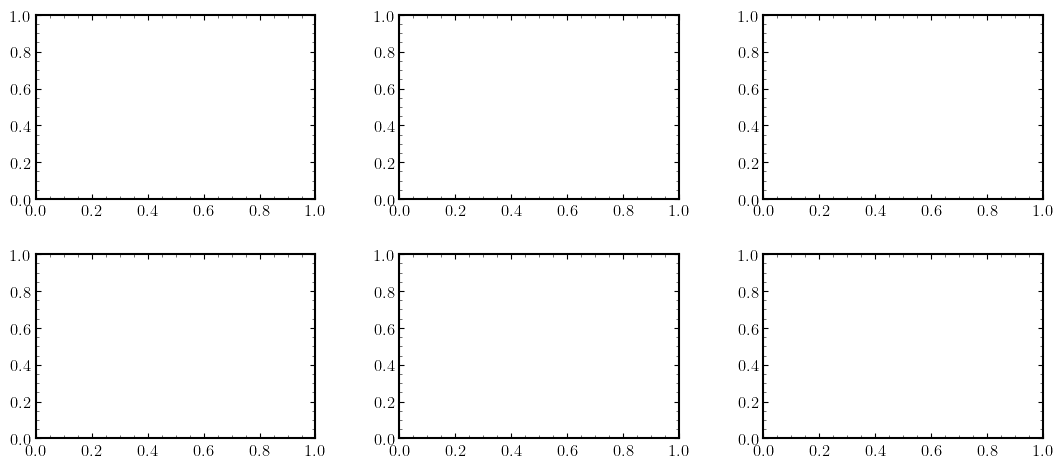

In [3]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
plotname= '1d-hists-reducedset' 

plt_1dhists(path, plotname, False)

0.3974609375
0.40234375
0.3994140625
0.4091796875
0.416015625
0.404296875
0.4248046875
0.439453125
0.416015625


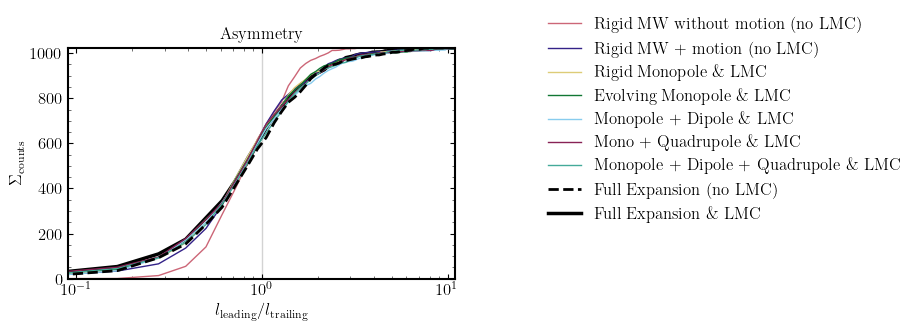

In [109]:
fig, ax = plt.subplots(1,1, figsize=(5,3))


potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                        'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5'])

labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
               'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC', 'Full Expansion (no LMC)', 'Full Expansion \& LMC'])

for j in range(len(potentials)): 

    with h5py.File(path + potentials[j],'r') as file:

        lons = np.array(file['lons'])
        l_lead = np.nanpercentile(lons, 95, axis=1)
        l_trail = np.nanpercentile(lons, 5, axis=1)
        asymmetry = np.abs(l_lead/l_trail)
        print(len(asymmetry[asymmetry>=10**0])/len(asymmetry))
    # asymmetry
    h, bin_edges = np.histogram(asymmetry, bins=np.linspace(0, 11, 100))
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
    if j==8:
        plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
    elif j==7:
        plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
    else:
        plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        
    plt.vlines(1, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
    plt.xlabel(r'$l_{\mathrm{leading}}/l_{\mathrm{trailing}}$')
    plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
    plt.xlim(0.09, 11)
    plt.xscale('log')
    plt.ylim(0,1024)
    plt.title('Asymmetry')
    plt.legend(frameon=False, ncol=1, fontsize=12, bbox_to_anchor=(1.2,1.2))

In [110]:
def plt_1dhists_cumulative(path, plotname, savefig=False):
    fig, ax = plt.subplots(4,2, figsize=(10,12))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                           'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                            'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5'])

    labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
                   'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC', 'Full Expansion (no LMC)', 'Full Expansion \& LMC'])

    for j in range(len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:
            lengths = np.array(file['lengths'])
            widths = np.array(file['widths'])
            loc_veldis = np.array(file['loc_veldis'])
            # energies = np.array(file['energies'])
            track_deform = np.array(file['track_deform'])
            # Ls = np.array(file['L'])
            # Lzs = np.array(file['Lz'])
            
            lons = np.array(file['lons'])
            l_lead = np.nanpercentile(lons, 95, axis=1)
            l_trail = np.nanpercentile(lons, 5, axis=1)
            asymmetry = np.abs(l_lead/l_trail)
            
            t_idx = -1
            l_pole = np.array(file['pole_l'])[:,t_idx]
            l_pole_std = np.nanstd(l_pole, axis=1)
            b_pole = np.array(file['pole_b'])[:,t_idx]
            b_pole_std = np.nanstd(b_pole, axis=1)

        # lengths
        plt.sca(ax[0,0])
        h, bin_edges = np.histogram(lengths, bins=np.linspace(-1, 360, 100))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.xlabel(r'$l_{\mathrm{stream}}\,[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0, 360)
        plt.ylim(0,1024)
        plt.xscale('log')
        # plt.legend(frameon=False, ncol=3, fontsize=12, bbox_to_anchor=(2.7,1.75))
        plt.title('Length')

        #widths
        plt.sca(ax[0,1])
        h, bin_edges = np.histogram(widths, bins=np.linspace(0., 3, 100))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(0.5, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$w\,[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0,)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Width')

        # velocity dispersion
        plt.sca(ax[1,0])
        h, bin_edges = np.histogram(loc_veldis, bins=np.linspace(0, 20, 100))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2.5, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{v}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0,20)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Local velocity dispersion')
        
        # track deformation
        plt.sca(ax[1,1])
        h, bin_edges = np.histogram(track_deform, bins=np.linspace(-0., 10, 100))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(1, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\bar{\delta}\,[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.,)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Deviation from Great Circle')
        
        # median l pole spread
        plt.sca(ax[2,0])
        h, bin_edges = np.histogram(l_pole_std, bins=np.linspace(0, 50, 500))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{l,\,{\mathrm{pole}}}[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0,25)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Longitudinal pole spread')
        
        # median b pole spread
        plt.sca(ax[2,1])
        h, bin_edges = np.histogram(b_pole_std, bins=np.linspace(0, 10, 200))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{b,\,{\mathrm{pole}}}[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0,10)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Latitudinal pole spread')
        
        # asymmetry
        plt.sca(ax[3,0])
        h, bin_edges = np.histogram(asymmetry, bins=np.linspace(0, 11, 150))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.xlabel(r'$l_{\mathrm{leading}}/l_{\mathrm{trailing}}$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.09, 11)
        plt.xscale('log')
        plt.ylim(0,1024)
        plt.title('Asymmetry')
        plt.legend(frameon=False, ncol=1, fontsize=12, bbox_to_anchor=(1.2,1.2))
        # Median distance to stream
        # plt.sca(ax[3,1])
        ax[3,1].set_visible(False)
        
    if savefig==False:
        return
    elif savefig==True:
        savepath = '/mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/{}'.format(plotname)
        print('* Saving figure at {}.pdf'.format(savepath))
        plt.savefig(savepath)
    # plt.close()

/tmp/ipykernel_878314/962146405.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 360)
/tmp/ipykernel_878314/962146405.py:66: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,)
/tmp/ipykernel_878314/962146405.py:85: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,20)
/tmp/ipykernel_878314/962146405.py:104: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,)
/tmp/ipykernel_878314/962146405.py:123: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,25)
/tmp/ipykernel_878314/962146405.py:142: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,10)


* Saving figure at /mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/1d-hists-cumulative.pdf


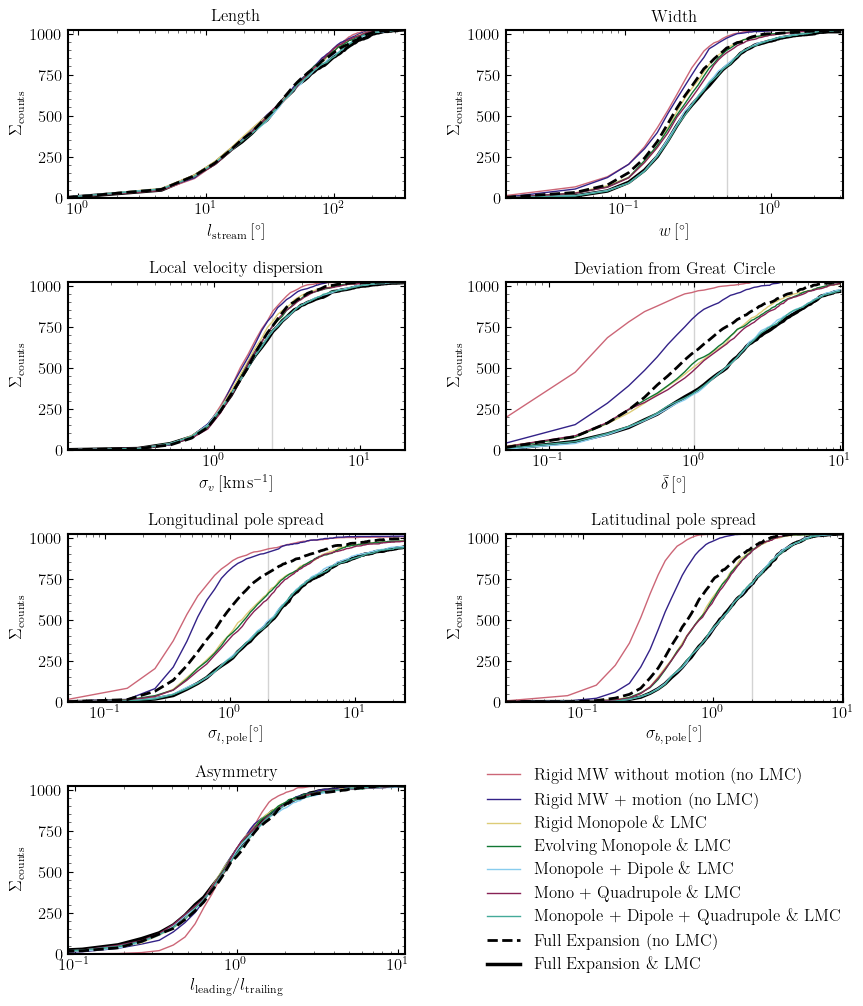

In [111]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
plotname= '1d-hists-cumulative' 

plt_1dhists_cumulative(path, plotname, True)

In [14]:
def plt_1dhists_reltostatic(path, plotname, savefig=False):
    fig, ax = plt.subplots(2,3, figsize=(13,5.5))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

#     potentials = list(['rigid-mw.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
#                            'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
#                            'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])

#     labels = list(['Rigid MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
#                    'Monopole + Dipole + Quadrupole', 'Full Expansion', 'Full Expansion (no LMC)'])
    
    potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5',
                        'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])

    labels = list(['Rigid MW (no motion)','Rigid MW (with motion)', 'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 
                'Full Expansion \& LMC', 'Full Expansion (no LMC)'])
    
    with h5py.File(path + potentials[0],'r') as file:

            lengths_0 = np.array(file['lengths'])
            widths_0 = np.array(file['widths'])
            loc_veldis_0 = np.array(file['loc_veldis'])
            track_deform_0 = np.array(file['track_deform'])
          
            t_idx = -1
            l_pole = np.array(file['pole_l'])[:,t_idx]
            l_pole_std_0 = np.nanstd(l_pole, axis=1)
            b_pole = np.array(file['pole_b'])[:,t_idx]
            b_pole_std_0 = np.nanstd(b_pole, axis=1)

    for j in range(0, len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:
            lengths = np.array(file['lengths'])
            widths = np.array(file['widths'])
            loc_veldis = np.array(file['loc_veldis'])
            track_deform = np.array(file['track_deform'])
         
            t_idx = -1
            l_pole = np.array(file['pole_l'])[:,t_idx]
            l_pole_std = np.nanstd(l_pole, axis=1)
            b_pole = np.array(file['pole_b'])[:,t_idx]
            b_pole_std = np.nanstd(b_pole, axis=1)

        # lengths
        plt.sca(ax[0,0])
        h, bin_edges = np.histogram(lengths, bins=np.linspace(-1, 360, 10))
        h_0, bin_edges_0 = np.histogram(lengths_0, bins=np.linspace(-1, 360, 10))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        plt.plot(bin_mids, h - h_0, label=labels[j])
        plt.xlabel(r'$l\,[^{\circ}]$')
        plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
        plt.xlim(0, 360)
        # plt.ylim(0.1,)
        plt.legend(frameon=False, ncol=3, fontsize=12, bbox_to_anchor=(3.,1.35))

        #widths
        plt.sca(ax[1,0])
        h, bin_edges = np.histogram(widths, bins=np.linspace(-0., 3, 15))
        h_0, bin_edges_0 = np.histogram(widths_0, bins=np.linspace(-0., 3, 15))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        plt.plot(bin_mids, h - h_0)
        plt.xlabel(r'$w\,[^{\circ}]$')
        plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
        plt.xlim(0,)
        # plt.ylim(0.1,)

        # velocity dispersion
        plt.sca(ax[0,1])
        h, bin_edges = np.histogram(loc_veldis, bins=np.linspace(-0, 20, 15))
        h_0, bin_edges_0 = np.histogram(loc_veldis_0, bins=np.linspace(-0, 20, 15))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        plt.plot(bin_mids, h - h_0)
        plt.xlabel(r'$\sigma_{v}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
        plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
        plt.xlim(0,20)
        # plt.ylim(0.1,)
        
        # track deformation
        plt.sca(ax[1,1])
        h, bin_edges = np.histogram(track_deform, bins=np.linspace(-0., 10, 25))
        h_0, bin_edges_0 = np.histogram(track_deform_0, bins=np.linspace(-0, 10, 25))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        plt.plot(bin_mids, h - h_0)
        plt.xlabel(r'$\bar{\delta}\,[^{\circ}]$')
        plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
        plt.xlim(-0.,)
        # plt.ylim(0.1,)

        # median l pole spread
        plt.sca(ax[0,2])
        h, bin_edges = np.histogram(l_pole_std, bins=np.linspace(0, 50, 30))
        h_0, bin_edges_0 = np.histogram(l_pole_std_0, bins=np.linspace(0, 50, 30))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        plt.plot(bin_mids, h - h_0)
        plt.xlabel(r'$\sigma_{l,\,{\mathrm{pole}}}[^{\circ}]$')
        plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
        plt.xlim(0,25)
        # plt.ylim(0.1,)
        
        # median b pole spread
        plt.sca(ax[1,2])
        h, bin_edges = np.histogram(b_pole_std, bins=np.linspace(0, 10, 20))
        h_0, bin_edges_0 = np.histogram(b_pole_std_0, bins=np.linspace(0, 10, 20))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        plt.plot(bin_mids, h - h_0)
        plt.xlabel(r'$\sigma_{b,\,{\mathrm{pole}}}[^{\circ}]$')
        plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
        plt.xlim(0,10)
        # plt.ylim(0.1,)
        
    if savefig==False:
        return
    elif savefig==True:
        savepath = '/mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/{}'.format(plotname)
        print('* Saving figure at {}.pdf'.format(savepath))
        plt.savefig(savepath)
    # plt.close()

* Saving figure at /mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/1d-hists-reltorigid.pdf


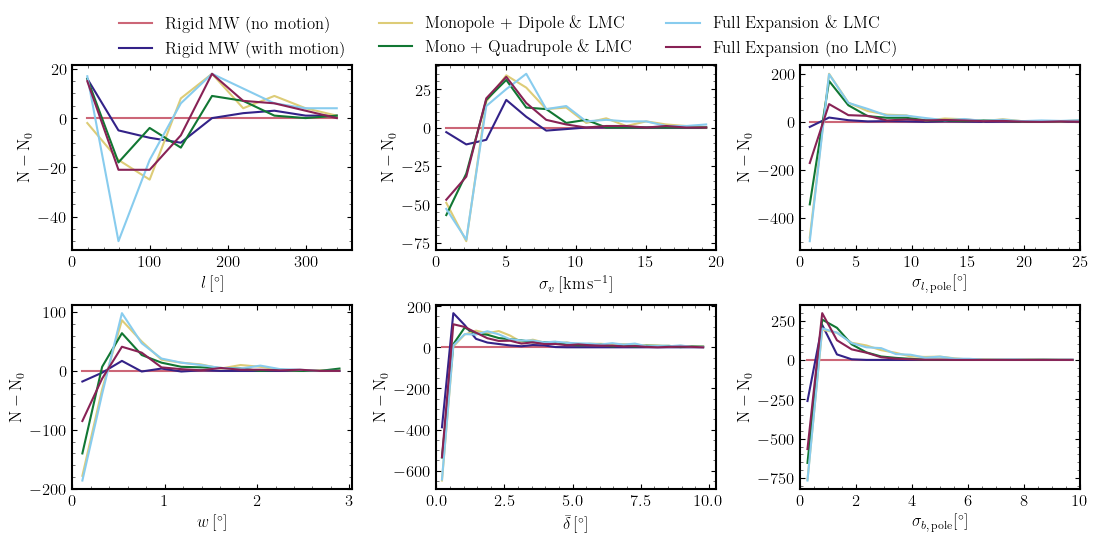

In [15]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
plotname= '1d-hists-reltorigid' 

plt_1dhists_reltostatic(path, plotname, True)

In [62]:
def plt_1dhists_quadrants(path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                           'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                           'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                   'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
    quadrants = list(['Q1', 'Q2', 'Q3', 'Q4'])
    
    fig, ax = plt.subplots(6,len(potentials), figsize=(24,12))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    for j in range(len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:
            
            l_gc,b_gc  = np.array(file['l_gc']), np.array(file['b_gc'])
            mask_q1 = ( (l_gc > 0) & (l_gc < 180) & (b_gc > 0) & (b_gc < 90) )
            mask_q2 = ( (l_gc > 180) & (l_gc < 360) & (b_gc > 0) & (b_gc < 90) )
            mask_q3 = ( (l_gc > 0) & (l_gc < 180) & (b_gc > -90) & (b_gc < 0) )
            mask_q4 = ( (l_gc > 180) & (l_gc < 360) & (b_gc > -90) & (b_gc < 0) )
            
            masks = [mask_q1, mask_q2, mask_q3, mask_q4]
            
            lengths = np.array(file['lengths'])
            widths = np.array(file['widths'])
            loc_veldis = np.array(file['loc_veldis'])
            energies = np.array(file['energies'])
            track_deforms = np.array(file['track_deform'])
            Ls = np.array(file['L'])
            Lzs = np.array(file['Lz'])
            
            # print(track_deforms)
            
        for m in range(len(masks)):
        
            # lengths
            plt.sca(ax[0,j])
            h, bin_edges = np.histogram(lengths[masks[m]], bins=np.linspace(-1, 360, 10))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h, label=quadrants[m])
            plt.xlabel(r'$l\,[^{\circ}]$')
            plt.xlim(0, 360)
            plt.ylim(0.1,)
            if j==0:
                plt.legend(frameon=False,fontsize=10)

            #widths
            plt.sca(ax[1,j])
            h, bin_edges = np.histogram(widths[masks[m]], bins=np.linspace(0, 3, 15))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$w\,[^{\circ}]$', fontsize=14)
            plt.xlim(0,)
            plt.ylim(0.1,)

            # velocity dispersion
            plt.sca(ax[2,j])
            h, bin_edges = np.histogram(loc_veldis[masks[m]], bins=np.linspace(0, 20, 15))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$\sigma_{v}\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
            plt.xlim(0,20)
            plt.ylim(0.1,)
            
            # track deforms
            plt.sca(ax[3,j])
            h, bin_edges = np.histogram(track_deforms[masks[m]], bins=np.linspace(-0., 10,15))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$\bar{\delta}\,[^{\circ}]$', fontsize=14)
            plt.ylim(0.1,)

            # median energies
            plt.sca(ax[4,j])
            h, bin_edges = np.histogram(np.log10(-energies)[masks[m]], bins=np.linspace(4, 5.5, 25))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$\log_{10}(\bar{E})\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=14)
            plt.xlim(4,5.5)
            plt.ylim(0.1,)

            # # median L
            # plt.sca(ax[4,j])
            # h, bin_edges = np.histogram(Ls[masks[m]], bins=np.linspace(0, 6500, 20))
            # bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            # plt.plot(bin_mids, h)
            # plt.xlabel(r'$L\,[\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{kpc}]$', fontsize=14)
            # plt.ylim(0.1,)

            # median Lz
            plt.sca(ax[5,j])
            h, bin_edges = np.histogram(Lzs[masks[m]], bins=np.linspace(-6000, 6000, 20))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$L_{z}\,[\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{kpc}]$', fontsize=14)
            plt.ylim(0.1,)
        
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    for k in range(len(labels)):
        ax[0,k].set_title(labels[k], fontsize=14)
        
    for l in range(6):
        ax[l, 0].set_ylabel('Counts', fontsize=14)
        
    if savefig==False:
        return
    elif savefig==True:
        savepath = '/mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/{}'.format(plotname)
        print('* Saving figure at {}.pdf'.format(savepath))
        plt.savefig(savepath)
    # plt.close()

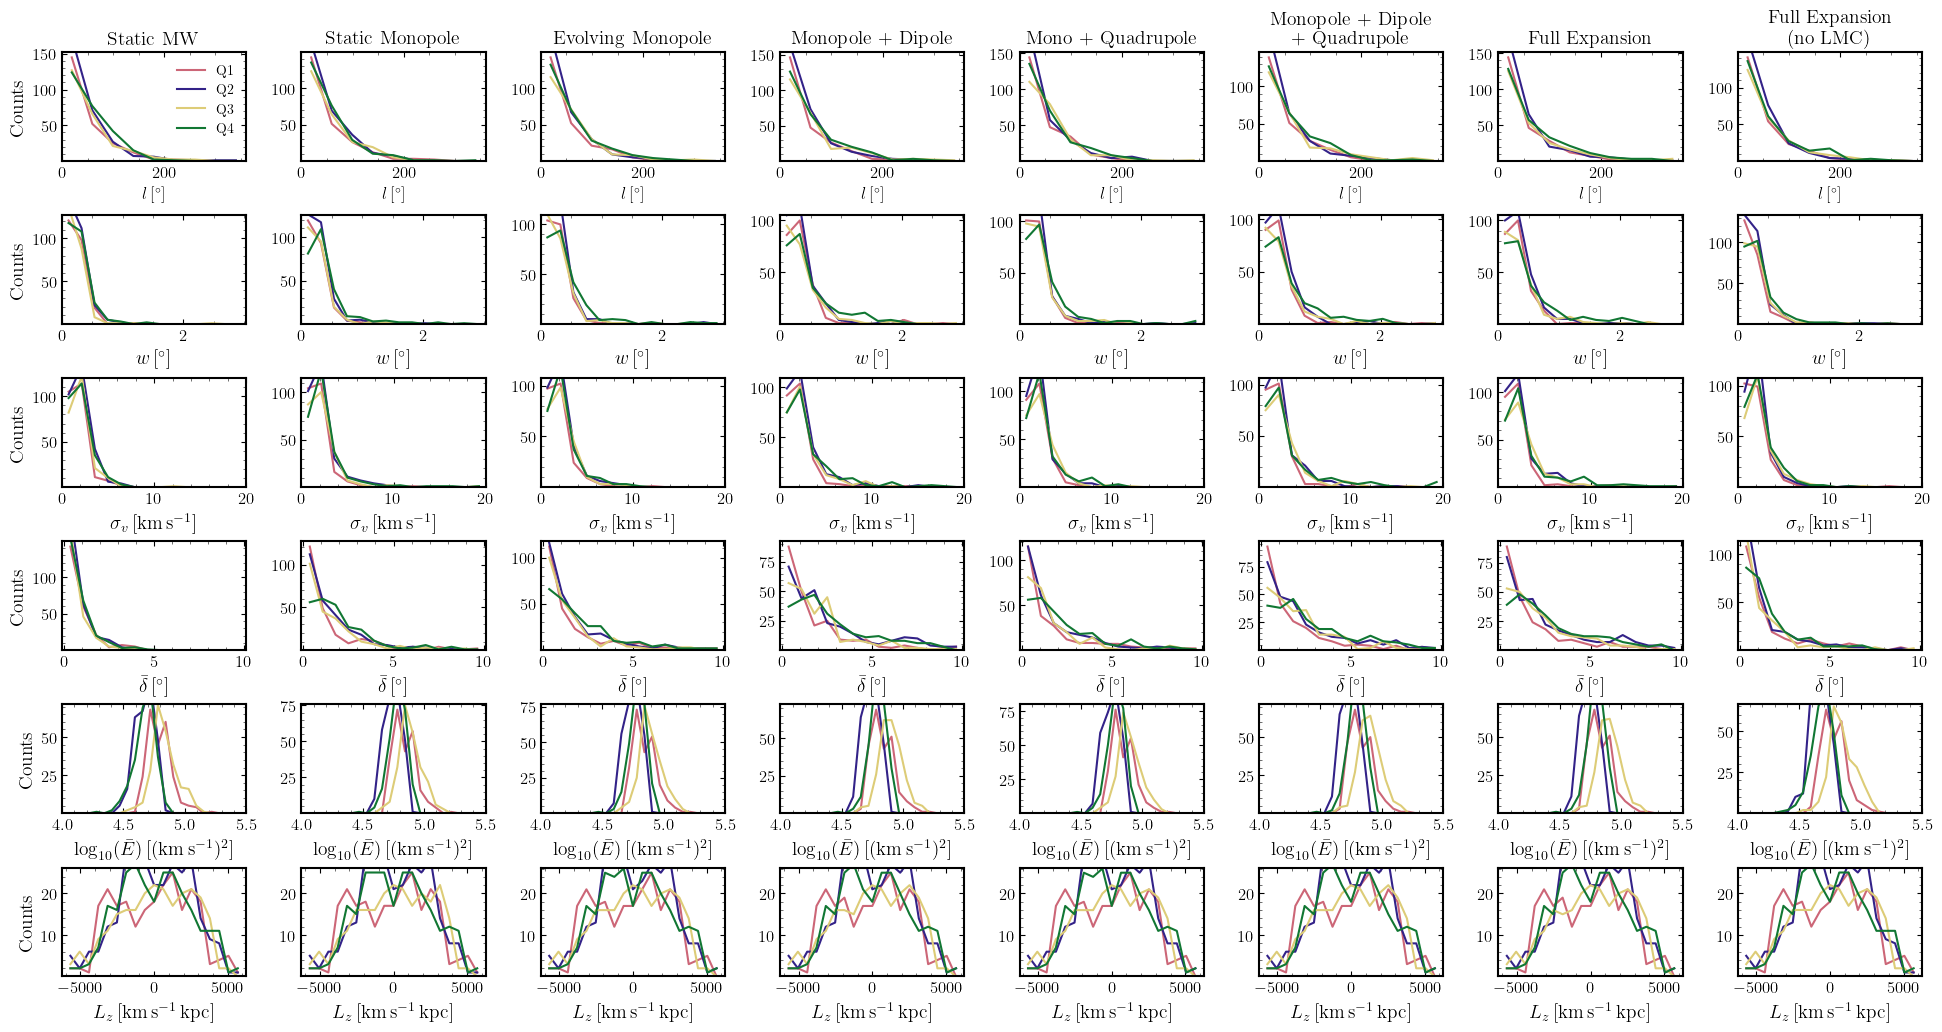

In [63]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
plotname= '1d-hists-quad' 

plt_1dhists_quadrants(path, plotname, False)